# Project 3: Predicting Taxi Ride Duration
## Material in this notebook can be attributed to the Fall 2019 version of Data 100 at UC Berkeley.
All work in this notebook, besides the provided code, belongs to me. 
This project was completed as part of my Data Science coursework at UC Berkeley.


In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

## The Data
Attributes of all [yellow taxi](https://en.wikipedia.org/wiki/Taxicabs_of_New_York_City) trips in January 2016 are published by the [NYC Taxi and Limosine Commission](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

The full data set takes a long time to download directly, so we've placed a simple random sample of the data into `taxi.db`, a SQLite database. You can view the code used to generate this sample in the `taxi_sample.ipynb` file included with this project (not required).

Columns of the `taxi` table in `taxi.db` include:
- `pickup_datetime`: date and time when the meter was engaged
- `dropoff_datetime`: date and time when the meter was disengaged
- `pickup_lon`: the longitude where the meter was engaged
- `pickup_lat`: the latitude where the meter was engaged
- `dropoff_lon`: the longitude where the meter was disengaged
- `dropoff_lat`: the latitude where the meter was disengaged
- `passengers`: the number of passengers in the vehicle (driver entered value)
- `distance`: trip distance
- `duration`: duration of the trip in seconds

Your goal will be to predict `duration` from the pick-up time, pick-up and drop-off locations, and distance.

## Part 1: Data Selection and Cleaning

Limiting data to trips that take place on Manhattan Island.

Only include trips that have **both** pick-up and drop-off locations within the boundaries of New York City:

- Longitude is between -74.03 and -73.75 (inclusive of both boundaries)
- Latitude is between 40.6 and 40.88 (inclusive of both boundaries)

In [6]:
import sqlite3

conn = sqlite3.connect('taxi.db')
lon_bounds = [-74.03, -73.75]
lat_bounds = [40.6, 40.88]

query1a = ''' SELECT * FROM taxi 
    WHERE pickup_lon >= -74.03 AND pickup_lon <= -73.75
        AND pickup_lat >= 40.6 AND pickup_lat <= 40.88
        AND dropoff_lon >= -74.03 AND dropoff_lon <= -73.75
        AND dropoff_lat >= 40.6 AND dropoff_lat <= 40.88
'''

all_taxi = pd.read_sql(query1a, conn)
all_taxi.head()

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,1,3.99,981
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299
3,2016-01-01 04:13:41,2016-01-01 04:19:24,-73.944725,40.714539,-73.955421,40.719173,1,0.80,343
4,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470


A scatter plot of pickup locations shows that most of them are on the island of Manhattan. The empty white rectangle is Central Park; cars are not allowed there.

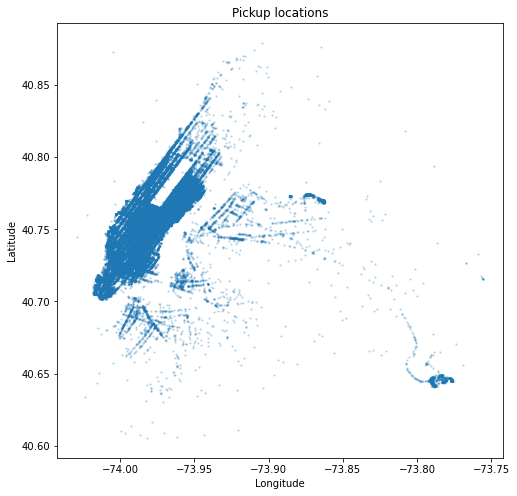

In [8]:
def pickup_scatter(t):
    plt.scatter(t['pickup_lon'], t['pickup_lat'], s=2, alpha=0.2)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Pickup locations')
    
plt.figure(figsize=(8, 8))
pickup_scatter(all_taxi)

The two small blobs outside of Manhattan with very high concentrations of taxi pick-ups are airports.

`clean_taxi` only includes trips with a positive passenger count, a positive distance, a duration of at least 1 minute and at most 1 hour, and an average speed of at most 100 miles per hour. 

In [9]:
all_taxi["mph"] = all_taxi['distance'] / (all_taxi['duration'] / 3600)
clean_taxi = all_taxi.query("passengers > 0 & duration >= 60 & distance > 0 & duration <= 3600 & mph <= 100").drop(columns=['mph'])
clean_taxi

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,1,3.99,981
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299
3,2016-01-01 04:13:41,2016-01-01 04:19:24,-73.944725,40.714539,-73.955421,40.719173,1,0.80,343
4,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470
...,...,...,...,...,...,...,...,...,...
97687,2016-01-31 02:59:16,2016-01-31 03:09:23,-73.997391,40.721027,-73.978447,40.745277,1,2.17,607
97688,2016-01-14 22:48:10,2016-01-14 22:51:27,-73.988037,40.718761,-73.983337,40.726162,1,0.60,197
97689,2016-01-08 04:46:37,2016-01-08 04:50:12,-73.984390,40.754978,-73.985909,40.751820,4,0.79,215
97690,2016-01-31 12:55:54,2016-01-31 13:01:07,-74.008675,40.725979,-74.009598,40.716003,1,0.85,313


Create a DataFrame called `manhattan_taxi` that only includes trips from `clean_taxi` that start and end within a polygon that defines the boundaries of [Manhattan Island](https://www.google.com/maps/place/Manhattan,+New+York,+NY/@40.7590402,-74.0394431,12z/data=!3m1!4b1!4m5!3m4!1s0x89c2588f046ee661:0xa0b3281fcecc08c!8m2!3d40.7830603!4d-73.9712488).

The vertices of this polygon are defined in `manhattan.csv` as (latitude, longitude) pairs, which are [published here](https://gist.github.com/baygross/5430626).

In [10]:
polygon = pd.read_csv('manhattan.csv')

poly_lats, poly_lons = polygon['lat'].tolist(), polygon['lon'].tolist()

# Recommended: First develop and test a function that takes a position
#              and returns whether it's in Manhattan.  

def in_manhattan(x, y):
    """Whether a longitude-latitude (x, y) pair is in the Manhattan polygon."""
    num_corners = len(polygon)
    i, j = 0, num_corners - 1
    odd_nodes = False
    
    while i < num_corners:
        if (((poly_lons[i] < x) & (poly_lons[j] >= x))
            | ((poly_lons[j] < x) & (poly_lons[i] >= x)) 
            & ((poly_lats[i] <= y) | (poly_lats[j] <= y))):
            if (poly_lats[i] + (x - poly_lons[i]) / (poly_lons[j] - poly_lons[i]) * (poly_lats[j] - poly_lats[i])) < y:
                if odd_nodes == True:
                    odd_nodes = False
                else:
                    odd_nodes = True
        j = i
        i += 1

    
    return odd_nodes

# Recommended: Then, apply this function to every trip to filter clean_taxi.

manhattan_taxi = clean_taxi[clean_taxi.apply(lambda x: in_manhattan(x['pickup_lon'], x['pickup_lat']), axis=1) & clean_taxi.apply(lambda x: in_manhattan(x['dropoff_lon'], x['dropoff_lat']), axis=1)]


A scatter diagram of only Manhattan taxi rides has the familiar shape of Manhattan Island. 

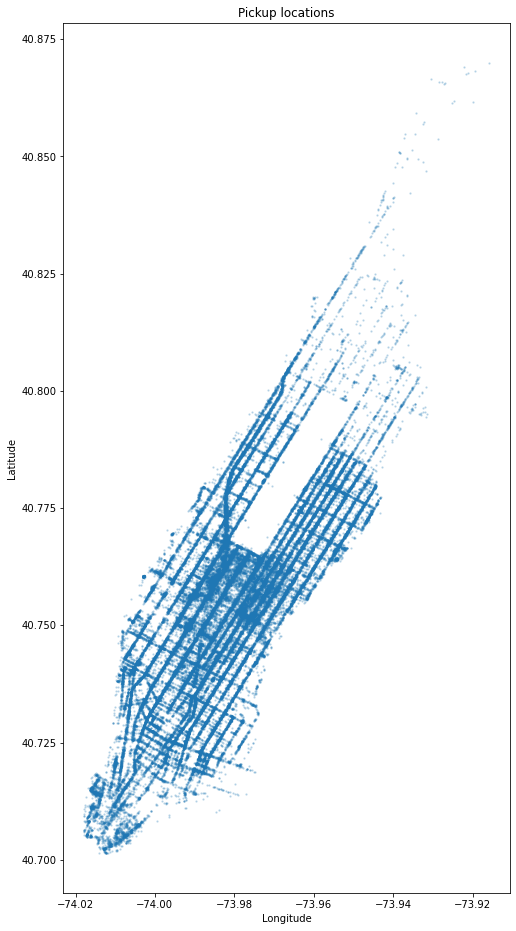

In [11]:
plt.figure(figsize=(8, 16))
pickup_scatter(manhattan_taxi)

In [12]:
original = len(all_taxi)
cleaned = len(clean_taxi)
percent_original = ((original - cleaned) / original * 100)
difference = original - cleaned
manhattan = len(manhattan_taxi)

print(f"From the original {original} trips, we initially cleaned a total of {difference} trips," + "\r\n" + f" or {percent_original}%, which then resulted in a cleaned dataset of {manhattan} trips in Manhattan.")

From the original 97692 trips, we initially cleaned a total of 1247 trips,
 or 1.276460713262089%, which then resulted in a cleaned dataset of 82800 trips in Manhattan.


## Part 2: Exploratory Data Analysis

In this part, you'll choose which days to include as training data in your regression model. 

Your goal is to develop a general model that could potentially be used for future taxi rides. There is no guarantee that future distributions will resemble observed distributions, but some effort to limit training data to typical examples can help ensure that the training data are representative of future observations.

January 2016 had some atypical days. New Years Day (January 1) fell on a Friday. MLK Day was on Monday, January 18. A [historic blizzard](https://en.wikipedia.org/wiki/January_2016_United_States_blizzard) passed through New York that month. Using this dataset to train a general regression model for taxi trip times must account for these unusual phenomena, and one way to account for them is to remove atypical days from the training data.

Adding a column labeled `date` to `manhattan_taxi` that contains the date (but not the time) of pickup, formatted as a `datetime.date` value ([docs](https://docs.python.org/3/library/datetime.html#date-objects)). 


In [13]:

manhattan_taxi['date'] = pd.to_datetime(manhattan_taxi['pickup_datetime']).dt.date
manhattan_taxi.head()

/Users/lawduong/miniforge3/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration,date
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,1,3.99,981,2016-01-30
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320,2016-01-04
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299,2016-01-07
4,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470,2016-01-08
5,2016-01-02 12:39:57,2016-01-02 12:53:29,-73.958214,40.760525,-73.983360,40.760406,1,1.70,812,2016-01-02


Creating a bar chart that shows which dates were affected by the historic blizzard of January 2016.

(array([16801., 16805., 16809., 16813., 16817., 16821., 16825., 16829.,
        16832.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

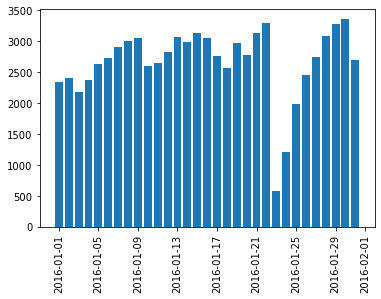

In [14]:
trip_counts = manhattan_taxi.groupby('date').count()['passengers']
plt.bar(trip_counts.index, trip_counts)
plt.xticks(rotation=90)

In [15]:
import calendar
import re

from datetime import date

atypical = [1, 2, 3, 18, 23, 24, 25, 26]
typical_dates = [date(2016, 1, n) for n in range(1, 32) if n not in atypical]
typical_dates

print('Typical dates:\n')
pat = '  [1-3]|18 | 23| 24|25 |26 '
print(re.sub(pat, '   ', calendar.month(2016, 1)))

final_taxi = manhattan_taxi[manhattan_taxi['date'].isin(typical_dates)]

Typical dates:

    January 2016
Mo Tu We Th Fr Sa Su
                    
 4  5  6  7  8  9 10
11 12 13 14 15 16 17
   19 20 21 22      
      27 28 29 30 31



## Part 3: Feature Engineering

Creating a design matrix for a linear regression mode. 
First Model: Predicint trip duration from the following inputs: start location, end location, trip distance, time of day, and day of the week (*Monday, Tuesday, etc.*). 

To evaluate the model, also split the data into a a train and test split.

In [16]:
import sklearn.model_selection

train, test = sklearn.model_selection.train_test_split(
    final_taxi, train_size=0.8, test_size=0.2, random_state=42)
print('Train:', train.shape, 'Test:', test.shape)

Train: (53680, 10) Test: (13421, 10)



Creating a boxplot to compare the distributions of taxi trip durtions for each day (using the train dataset only).

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 [Text(0, 0, '2016-01-21'),
  Text(1, 0, '2016-01-29'),
  Text(2, 0, '2016-01-04'),
  Text(3, 0, '2016-01-09'),
  Text(4, 0, '2016-01-13'),
  Text(5, 0, '2016-01-12'),
  Text(6, 0, '2016-01-22'),
  Text(7, 0, '2016-01-10'),
  Text(8, 0, '2016-01-08'),
  Text(9, 0, '2016-01-14'),
  Text(10, 0, '2016-01-19'),
  Text(11, 0, '2016-01-30'),
  Text(12, 0, '2016-01-31'),
  Text(13, 0, '2016-01-27'),
  Text(14, 0, '2016-01-05'),
  Text(15, 0, '2016-01-06'),
  Text(16, 0, '2016-01-28'),
  Text(17, 0, '2016-01-11'),
  Text(18, 0, '2016-01-20'),
  Text(19, 0, '2016-01-07'),
  Text(20, 0, '2016-01-17'),
  Text(21, 0, '2016-01-15'),
  Text(22, 0, '2016-01-16')])

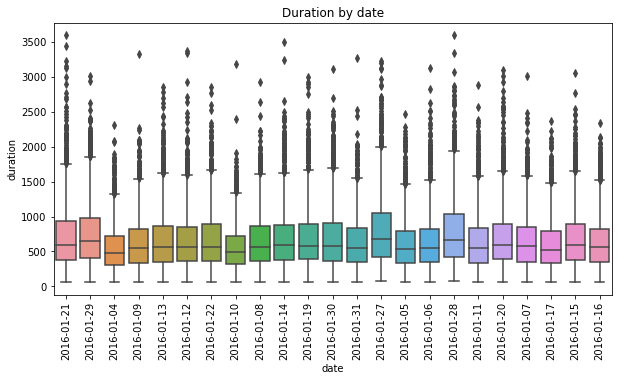

In [17]:
plt.figure(figsize=(10,5))
sns.boxplot(x=train['date'], y=train['duration'])
plt.title('Duration by date')
plt.xticks(rotation=90)


During the weekends, such as Friday through Sunday, we can see that the duration of a taxi trip is much shorter than other days - looking at the boxplot, 1/09, 1/10, 1/17, and 1/31 are all one of the above days of the week and we can definitely see shorter durations. On the other hand, Thursdays such as 1/21 and 1/28, tend to have much greater durations of trips.

Below, the provided `augment` function adds various columns to a taxi ride dataframe. 

- `hour`: The integer hour of the pickup time. E.g., a 3:45pm taxi ride would have `15` as the hour. A 12:20am ride would have `0`.
- `day`: The day of the week with Monday=0, Sunday=6.
- `weekend`: 1 if and only if the `day` is Saturday or Sunday.
- `period`: 1 for early morning (12am-6am), 2 for daytime (6am-6pm), and 3 for night (6pm-12pm).
- `speed`: Average speed in miles per hour.


In [18]:
def speed(t):
    """Return a column of speeds in miles per hour."""
    return t['distance'] / t['duration'] * 60 * 60

def augment(t):
    """Augment a dataframe t with additional columns."""
    u = t.copy()
    pickup_time = pd.to_datetime(t['pickup_datetime'])
    u.loc[:, 'hour'] = pickup_time.dt.hour
    u.loc[:, 'day'] = pickup_time.dt.weekday
    u.loc[:, 'weekend'] = (pickup_time.dt.weekday >= 5).astype(int)
    u.loc[:, 'period'] = np.digitize(pickup_time.dt.hour, [0, 6, 18])
    u.loc[:, 'speed'] = speed(t)
    return u
    
train = augment(train)
test = augment(test)
train.iloc[0,:] # An example row

pickup_datetime     2016-01-21 18:02:20
dropoff_datetime    2016-01-21 18:27:54
pickup_lon                   -73.994202
pickup_lat                    40.751019
dropoff_lon                  -73.963692
dropoff_lat                   40.771069
passengers                            1
distance                           2.77
duration                           1534
date                         2016-01-21
hour                                 18
day                                   3
weekend                               0
period                                3
speed                          6.500652
Name: 16548, dtype: object

Now compairing the distribution of average speeds for taxi rides that start at differnet times of the day.
- Early morning (12am-6am)
- Day (6am-6pm; 12 hours)
- Night (6pm-12am; 6 hours)

/Users/lawduong/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lawduong/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lawduong/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

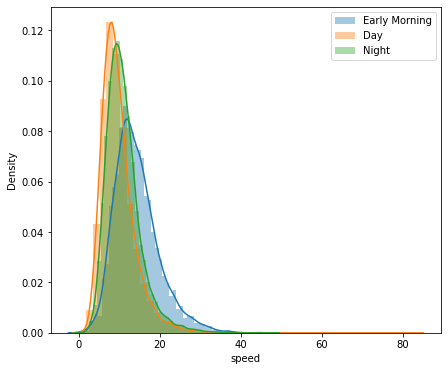

In [19]:
plt.figure(figsize=(7, 6))
sns.distplot(train.query("period == 1")['speed'], label='Early Morning')
sns.distplot(train.query("period == 2")['speed'], label='Day')
sns.distplot(train.query("period == 3")['speed'], label='Night')
plt.legend()

### Principal Component Analysis
Manhattan can roughly be divided into Lower, Midtown, and Upper regions. Instead of studying a map, let's approximate by finding the first principal component of the pick-up location (latitude and longitude). Before doing that, let's once again take a look at a scatterplot of trips in Manhattan:

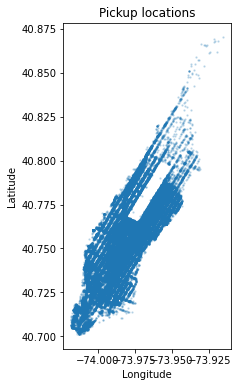

In [20]:
plt.figure(figsize=(3, 6))
pickup_scatter(manhattan_taxi)


In [21]:
# Find the first principal component
D = train[['pickup_lon', 'pickup_lat']]
pca_n = len(D)
pca_means = np.mean(D)
X = (D - pca_means) / np.sqrt(pca_n)
u, s, vt = np.linalg.svd(X, full_matrices=False)

def add_region(t):
    """Add a region column to t based on vt above."""
    D = t[['pickup_lon', 'pickup_lat']]
    assert D.shape[0] == t.shape[0], 'You set D using the incorrect table'
    # Always use the same data transformation used to compute vt
    X = (D - pca_means) / np.sqrt(pca_n) 
    first_pc = X @ vt.T[:, 0]
    t.loc[:,'region'] = pd.qcut(first_pc, 3, labels=[0, 1, 2])
    
add_region(train)
add_region(test)



Let's see how PCA divided the trips into three groups. These regions do roughly correspond to Lower Manhattan (below 14th street), Midtown Manhattan (between 14th and the park), and Upper Manhattan (bordering Central Park). No prior knowledge of New York geography was required!

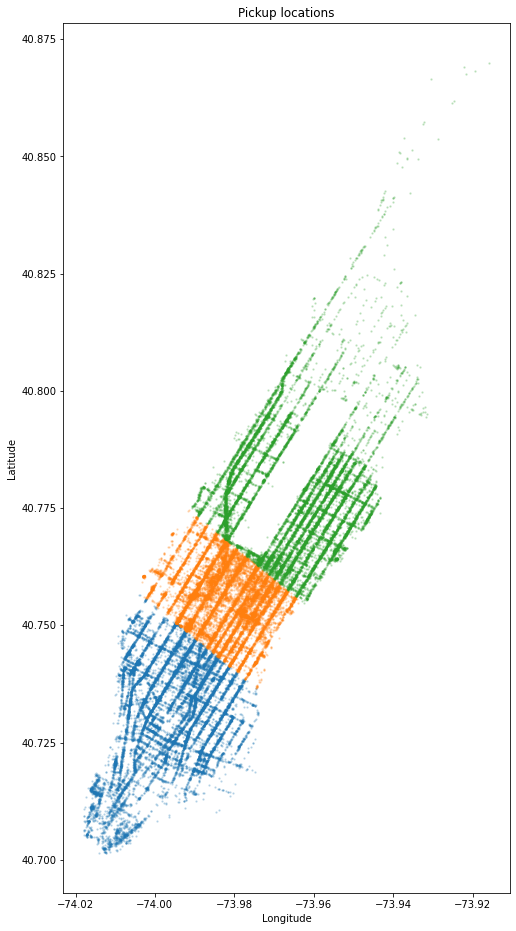

In [22]:
plt.figure(figsize=(8, 16))
for i in [0, 1, 2]:
    pickup_scatter(train[train['region'] == i])

/Users/lawduong/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lawduong/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/lawduong/miniforge3/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar fle

<AxesSubplot:xlabel='speed', ylabel='Density'>

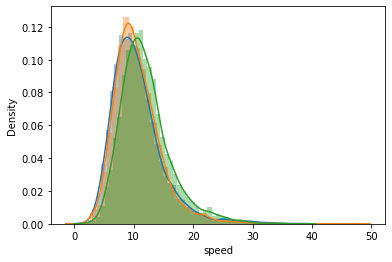

In [23]:
sns.distplot(train.query("period == 3 & region == 0")['speed'])
sns.distplot(train.query("period == 3 & region == 1")['speed'])
sns.distplot(train.query("period == 3 & region == 2")['speed'])

Finally, we create a design matrix that includes many of these features. Quantitative features are converted to standard units, while categorical features are converted to dummy variables using one-hot encoding. The `period` is not included because it is a linear combination of the `hour`. The `weekend` variable is not included because it is a linear combination of the `day`.  The `speed` is not included because it was computed from the `duration`; it's impossible to know the speed without knowing the duration, given that you know the distance.

In [24]:
from sklearn.preprocessing import StandardScaler

num_vars = ['pickup_lon', 'pickup_lat', 'dropoff_lon', 'dropoff_lat', 'distance']
cat_vars = ['hour', 'day', 'region']

scaler = StandardScaler()
scaler.fit(train[num_vars])

def design_matrix(t):
    """Create a design matrix from taxi ride dataframe t."""
    scaled = t[num_vars].copy()
    scaled.iloc[:,:] = scaler.transform(scaled) # Convert to standard units
    categoricals = [pd.get_dummies(t[s], prefix=s, drop_first=True) for s in cat_vars]
    return pd.concat([scaled] + categoricals, axis=1)

design_matrix(train).iloc[0,:]  

pickup_lon    -0.805821
pickup_lat    -0.171761
dropoff_lon    0.954062
dropoff_lat    0.624203
distance       0.626326
hour_1         0.000000
hour_2         0.000000
hour_3         0.000000
hour_4         0.000000
hour_5         0.000000
hour_6         0.000000
hour_7         0.000000
hour_8         0.000000
hour_9         0.000000
hour_10        0.000000
hour_11        0.000000
hour_12        0.000000
hour_13        0.000000
hour_14        0.000000
hour_15        0.000000
hour_16        0.000000
hour_17        0.000000
hour_18        1.000000
hour_19        0.000000
hour_20        0.000000
hour_21        0.000000
hour_22        0.000000
hour_23        0.000000
day_1          0.000000
day_2          0.000000
day_3          1.000000
day_4          0.000000
day_5          0.000000
day_6          0.000000
region_1       1.000000
region_2       0.000000
Name: 16548, dtype: float64

## Part 4: Model Selection

In this part, you will select a regression model to predict the duration of a taxi ride.


In [25]:
def rmse(errors):
    """Return the root mean squared error."""
    return np.sqrt(np.mean(errors ** 2))

constant_rmse = rmse(test['duration'] - np.mean(train['duration']))
constant_rmse

399.1437572352666

### Baseline Model

Creating our baseline model using 'simple_rmse' which is a simple linear regression model that uses only the duration of the taxi ride as a feature.



In [26]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(train[['distance']], train['duration'])
simple_rmse = rmse(test['duration'] - model.predict(test[['distance']]))
simple_rmse

276.784110500034

### Design Matrix Model
Calculating the rmse of the linear regression model fitted to the training set without regularization. Using our design matrix from before.

In [27]:
model = LinearRegression()
model.fit(design_matrix(train), train['duration'])
linear_rmse = rmse(test['duration'] - model.predict(design_matrix(test)))
linear_rmse

255.19146631882754

### Period Model

For each possible value of `period`, fit an unregularized linear regression model to the subset of the training set in that `period`.  RMSE of test set for a model that first chooses linear regression parameters based on the observed period of the taxi ride, then predicts the duration using those parameters. Again, fit to the training set and use the `design_matrix` function for features.

In [28]:
model = LinearRegression()
errors = []

for v in np.unique(train['period']):
    d_matrix = train[train['period'] == v]
    to_test = test[test['period'] == v]
    model.fit(design_matrix(d_matrix), d_matrix['duration'])
    errors.extend(to_test['duration'] - model.predict(design_matrix(to_test)))
    
period_rmse = rmse(np.array(errors))
period_rmse

246.6286883116518

### Observations

The period regression model might possibly outperform the linear regression model because it is fitting a unique regression model to each subset of the data according to the period of the day. The linear regression model simply generalizes to the entire day based on the hours of the trip, creating a single model.


Instead of predicting duration directly, an alternative is to predict the average *speed* of the taxi ride using linear regression, then compute an estimate of the duration from the predicted speed and observed distance for each ride.

### Speed Model

In [29]:
model = LinearRegression()
model.fit(design_matrix(train), train['speed'])
predicted_speed = model.predict(design_matrix(test))
predicted_duration = test['distance']/predicted_speed * 3600
speed_rmse = rmse(test['duration'] - predicted_duration)
speed_rmse

243.01798368514946

### Tree Regression Model

Finally, complete the function `tree_regression_errors` (and helper function `speed_error`) that combines the ideas from the two previous models and generalizes to multiple categorical variables.

The `tree_regression_errors` should:
- Find a different linear regression model for each possible combination of the variables in `choices`;
- Fit to the specified `outcome` (on train) and predict that `outcome` (on test) for each combination (`outcome` will be `'duration'` or `'speed'`);
- Use the specified `error_fn` (either `duration_error` or `speed_error`) to compute the error in predicted duration using the predicted outcome;
- Aggregate those errors over the whole test set and return them.

You should find that including each of `period`, `region`, and `weekend` improves prediction accuracy, and that predicting speed rather than duration leads to more accurate duration predictions.

In [30]:
model = LinearRegression()
choices = ['period', 'region', 'weekend']

def duration_error(predictions, observations):
    """Error between predictions (array) and observations (data frame)"""
    return predictions - observations['duration']

def speed_error(predictions, observations):
    """Duration error between speed predictions and duration observations"""
    return duration_error((observations['distance'] * 3600)/ predictions, observations)

def tree_regression_errors(outcome='duration', error_fn=duration_error):
    """Return errors for all examples in test using a tree regression model."""
    errors = []
    for vs in train.groupby(choices).size().index:
        v_train, v_test = train, test
        for v, c in zip(vs, choices):
            v_train = v_train[v_train[c] == v]
            v_test = v_test[v_test[c] == v]
            # print(v_train.shape, v_test.shape)
        model.fit(design_matrix(v_train), v_train[outcome])
        errors.extend(error_fn(model.predict(design_matrix(v_test)), v_test))
    return errors

errors = tree_regression_errors()
errors_via_speed = tree_regression_errors('speed', speed_error)
tree_rmse = rmse(np.array(errors))
tree_speed_rmse = rmse(np.array(errors_via_speed))
print('Duration:', tree_rmse, '\nSpeed:', tree_speed_rmse)

Duration: 240.3395219270353 
Speed: 226.90793945018308


### Results of all models

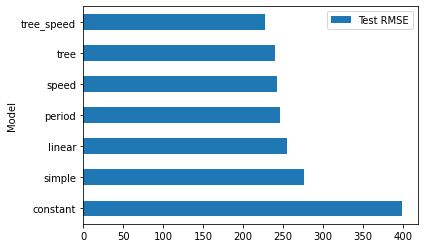

In [31]:
models = ['constant', 'simple', 'linear', 'period', 'speed', 'tree', 'tree_speed']
pd.DataFrame.from_dict({
    'Model': models,
    'Test RMSE': [eval(m + '_rmse') for m in models]
}).set_index('Model').plot(kind='barh');

**Congratulations**! You've carried out the entire data science lifecycle for a challenging regression problem. 

In Part 1 on data selection, you solved a domain-specific programming problem relevant to the analysis when choosing only those taxi rides that started and ended in Manhattan.

In Part 2 on EDA, you used the data to assess the impact of a historical event---the 2016 blizzard---and filtered the data accordingly.

In Part 3 on feature engineering, you used PCA to divide up the map of Manhattan into regions that roughly corresponded to the standard geographic description of the island.

In Part 4 on model selection, you found that using linear regression in practice can involve more than just choosing a design matrix. Tree regression made better use of categorical variables than linear regression. The domain knowledge that duration is a simple function of distance and speed allowed you to predict duration more accurately by first predicting speed.

Hopefully, it is apparent that all of these steps are required to reach a reliable conclusion about what inputs and model structure are helpful in predicting the duration of a taxi ride in Manhattan. 

## Future Work

Here are some questions to ponder:

- The regression model would have been more accurate if we had used the date itself as a feature instead of just the day of the week. Why didn't we do that?
- Does collecting this information about every taxi ride introduce a privacy risk? The original data also included the total fare; how could someone use this information combined with an individual's credit card records to determine their location?
- Why did we treat `hour` as a categorical variable instead of a quantitative variable? Would a similar treatment be beneficial for latitude and longitude?
- Why are Google Maps estimates of ride time much more accurate than our estimates?


Here are some possible extensions to the project:

- An alternative to throwing out atypical days is to condition on a feature that makes them atypical, such as the weather or holiday calendar. How would you do that?
- Training a different linear regression model for every possible combination of categorical variables can overfit. How would you select which variables to include in a decision tree instead of just using them all?
- Your models use the observed distance as an input, but the distance is only observed after the ride is over. How could you estimate the distance from the pick-up and drop-off locations?
- How would you incorporate traffic data into the model?